Week 5 Day 2

### AutoGen AgentChat - Going deeper..

1. Multi-modal conversation
2. Structured Outputs
3. Using LangChain tools
4. Teams

...and a special surprise extra piece

### This is an updated version of lab2 that shows usage of local models using Ollama.

Goal was to complete tasks, running local models <= 8b.


#### 1. Describe the content of this image in detail
Worked perfectly:

1. [llama3.2-vision:11b](https://ollama.com/library/llama3.2-vision:11b)
2. [gemma3:4b](https://ollama.com/library/gemma3:4b)

Even though **gemma3** is only 4b but results are really good.

#### 2. Find a one-way non-stop flight from JFK to LHR in June 2025

1. [qwen3:8b](https://ollama.com/library/qwen3:8b) - **qwen3:8b** was able to complete task with original prompts. Only one small addition was added - "/no_think" to disable thinking output.
2. [qwen3:4b](https://ollama.com/library/qwen3:4b) - **qwen3:4b was** able to search but not to write results. I had to rewrite a bit prompt and add "Remember to use tools to search and write files, this is very important /no_think". But as I said results are a bit flaky comparing to 8b and 14b.
3. [llama3.2:3b](https://ollama.com/library/llama3.2:3b) - **llama3.2:3b** was able to complete tasks.


In [16]:
from io import BytesIO
import requests
from autogen_agentchat.messages import TextMessage, MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image
from dotenv import load_dotenv
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import AssistantAgent
from autogen_core import CancellationToken
from IPython.display import display, Markdown
from pydantic import BaseModel, Field
from typing import Literal
from autogen_ext.models.ollama import OllamaChatCompletionClient

load_dotenv(override=True)

True

### A multi-modal conversation


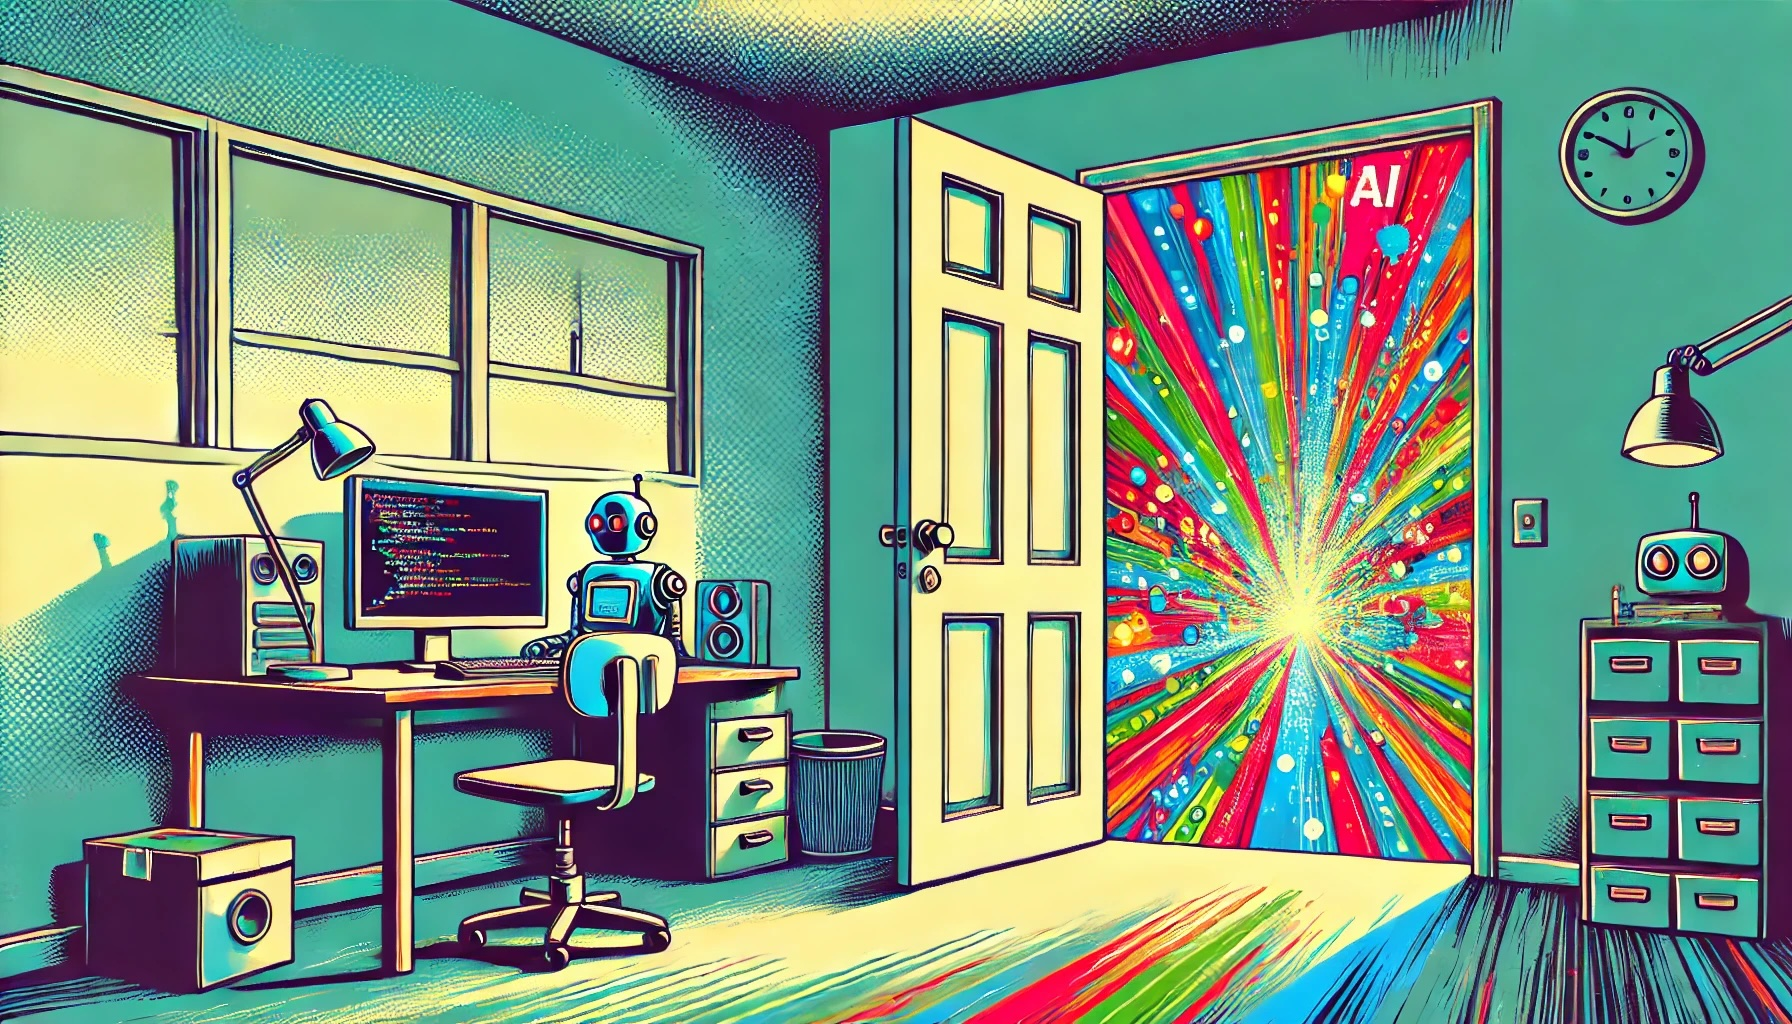

In [2]:
url = "https://edwarddonner.com/wp-content/uploads/2024/10/from-software-engineer-to-AI-DS.jpeg"

pil_image = Image.open(BytesIO(requests.get(url).content))
img = AGImage(pil_image)
img

In [3]:
multi_modal_message = MultiModalMessage(content=["Describe the content of this image in detail", img], source="User")

In [8]:
model_client = OllamaChatCompletionClient(
    model="gemma3:4b", # or "llama3.2-vision", which is much bigger - 11b!
    model_info={
        "vision": True,
        "function_calling": True,
        "json_output": True,
        "family": "unknown",
    },
)

describer = AssistantAgent(
    name="description_agent",
    model_client=model_client,
    system_message="You are good at describing images",
)

response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content
display(Markdown(reply))

Okay, here’s a detailed description of the image:

**Overall Impression:**

The image is a stylized, almost psychedelic illustration, likely a digital artwork. It has a retro-futuristic vibe, reminiscent of 1960s or 70s science fiction and art. The color palette is dominated by teal, turquoise, and a rainbow of vibrant colors within the door. The overall effect is slightly surreal and visually stimulating.

**The Room:**

*   **Walls & Color:** The walls of the room are a muted teal/turquoise color. This creates a calming, almost clinical backdrop for the more intense elements within the room.
*   **Window:** There's a large window on the left side of the frame, filled with a pale blue light.
*   **Furniture:** The room contains a minimalist workspace.
    *   **Desk:** A light-colored, simple desk occupies the foreground.
    *   **Chair:** A small, dark-colored ergonomic chair sits in front of the desk.
    *   **Speakers:** There are several small, round speakers placed on the desk, giving the impression of a sophisticated audio setup.
    *   **Trash Can:** A small, metallic trash can sits on the desk. 

**The Door and the Image Within:**

*   **The Door:** The dominant element is a large, double-door. The doors are dark in color, with a metallic finish. 
*   **The Image:** Inside the door, there’s a dazzling, swirling image of brilliant colors – primarily blues, reds, yellows, greens, and purples. It resembles a vibrant burst or explosion, with overlapping shapes and patterns. The text "AI" is boldly written across the center of the image. The image appears to be rendered in a chaotic, highly detailed manner. 

**Robots:** 

*  **Two Robots:** Two stylized robots are placed on the right side of the image, sitting on a small platform. They are dark gray in color with glowing red eyes and appear to be engaged in some activity. One robot is shown in front of a screen displaying code, while the other is simply observing. 

**Style & Details:**

*   **Illustration Style:** The image has a textured, hand-drawn look, likely created digitally using tools that emulate traditional illustration techniques.
*   **Line Work:** Strong, precise linework defines the shapes and forms, contributing to the artwork’s graphic quality.
*   **Lighting:** There's a soft, diffused light source illuminating the room, which adds to the overall atmosphere.

**Overall Theme:**

The image seems to represent the intersection of artificial intelligence, technology, and creative expression. The vibrant image within the door could symbolize the boundless potential and transformative nature of AI. 

Do you want me to focus on a specific aspect of the image, such as the robots or the door, or perhaps describe the details of the code on the screen?

### Structured Outputs!

Autogen AgentChat makes it easy.

In [11]:

class ImageDescription(BaseModel):
    scene: str = Field(description="Briefly, the overall scene of the image")
    message: str = Field(description="The point that the image is trying to convey")
    style: str = Field(description="The artistic style of the image")
    orientation: Literal["portrait", "landscape", "square"] = Field(description="The orientation of the image")


In [12]:
model_client = OllamaChatCompletionClient(
    model="gemma3:4b",
    model_info={
        "vision": True,
        "function_calling": True,
        "json_output": True,
        "family": "unknown",
    },
)

describer = AssistantAgent(
    name="description_agent",
    model_client=model_client,
    system_message="You are good at describing images in detail",
    output_content_type=ImageDescription,
)

response = await describer.on_messages([multi_modal_message], cancellation_token=CancellationToken())
reply = response.chat_message.content
reply

ImageDescription(scene='This image depicts a futuristic, slightly chaotic, and artistic workspace. The overall color palette is dominated by cool greens and blues, giving it a slightly artificial and tech-focused feel.', message='I will proceed with providing a detailed description of the image.', style='The image has a hand-drawn, almost comic book-style illustration with strong lines and a vibrant color scheme. The lines are thick and uneven, contributing to the slightly chaotic and energetic mood.', orientation='landscape')

In [13]:
import textwrap
print(f"Scene:\n{textwrap.fill(reply.scene)}\n\n")
print(f"Message:\n{textwrap.fill(reply.message)}\n\n")
print(f"Style:\n{textwrap.fill(reply.style)}\n\n")
print(f"Orientation:\n{textwrap.fill(reply.orientation)}\n\n")

Scene:
This image depicts a futuristic, slightly chaotic, and artistic
workspace. The overall color palette is dominated by cool greens and
blues, giving it a slightly artificial and tech-focused feel.


Message:
I will proceed with providing a detailed description of the image.


Style:
The image has a hand-drawn, almost comic book-style illustration with
strong lines and a vibrant color scheme. The lines are thick and
uneven, contributing to the slightly chaotic and energetic mood.


Orientation:
landscape




### Using LangChain tools from AutoGen

In [41]:
# AutoGen's wrapper:

from autogen_ext.tools.langchain import LangChainToolAdapter

# LangChain tools:

from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain.agents import Tool


prompt = """Your task is to find a one-way non-stop flight from JFK to LHR in June 2025.

Follow steps: 

1. First search online for promising deals.
2. Write all the deals to a file called flights.md with full details.
3. Select the best flight and write a short summary.
4. Reply with the selected flight only, and only after you have written the details to the file.

Remember to use tools to search and write files, this is very important /no_think"""

serper = GoogleSerperAPIWrapper()
langchain_serper =Tool(name="internet_search", func=serper.run, description="useful for when you need to search the internet")
autogen_serper = LangChainToolAdapter(langchain_serper)
autogen_tools = [autogen_serper]

langchain_file_management_tools = FileManagementToolkit(root_dir="sandbox").get_tools()
for tool in langchain_file_management_tools:
    autogen_tools.append(LangChainToolAdapter(tool))

for tool in autogen_tools:
    print(tool.name, tool.description)

model_client = OllamaChatCompletionClient(
    model="qwen3:4b", # or "qwen3:8b" and then you can use original prompts without any modifications
    model_info={
        "vision": True,
        "function_calling": True,
        "json_output": True,
        "family": "unknown",
    },
)
agent = AssistantAgent(name="searcher", model_client=model_client, tools=autogen_tools, reflect_on_tool_use=True)
message = TextMessage(content=prompt, source="user")
result = await agent.on_messages([message], cancellation_token=CancellationToken())
for message in result.inner_messages:
    print(message.content)
display(Markdown(result.chat_message.content))

internet_search useful for when you need to search the internet
copy_file Create a copy of a file in a specified location
file_delete Delete a file
file_search Recursively search for files in a subdirectory that match the regex pattern
move_file Move or rename a file from one location to another
read_file Read file from disk
write_file Write file to disk
list_directory List files and directories in a specified folder
[FunctionCall(id='0', arguments='{"query": "one-way non-stop flight from JFK to LHR in June 2025"}', name='internet_search')]
[FunctionExecutionResult(content='Book our best prices between New York and London within the next 6 months ; May 2025 · $589 · Seen: 2 hours ago ; Jun 2025 · $547 · Seen: undefined cmp-undefined ago. Cheap Flights from New York (JFK) to London (LHR) start at $187 for one-way and $394 for round trip ... The flight takes off from JFK on July 26 2025. Virgin Atlantic offers 45 nonstop flights per week. Virgin Atlantic flies from John F. Kennedy Intern

<think>

</think>

### flights.md
```
## Promising Deals for One-Way Non-Stop Flight from JFK to LHR in June 2025

1. **Flight Details:**
   - **Airline:** Virgin Atlantic
   - **Departure:** JFK, New York
   - **Arrival:** LHR, London
   - **Departure Date:** July 21, 2ity
   - **Price:** $194 per passenger
   - **Flight Type:** One-way
   - **Notes:** Non-stop flight with Virgin Atlantic, offers onboard entertainment and WiFi.

2. **Flight Details:**
   - **Airline:** jetBlue
   - **Departure:** JFK, New York
   - **Arrival:** LHR, London
   - **Departure Date:** July 26, 2025
   - **Price:** $187 per passenger
   - **Flight Type:** One-way
   - **Notes:** Non-stop flight with jetBlue, departing from JFK.

3. **Flight Details:**
   - **Airline:** British Airways
   - **Departure:** JFK, New York
   - **Arrival:** LHR, London
   - **Departure Date:** June 20, 2025
   - **Price:** $589 per passenger
   - **Flight Type:** One-way
   - **Notes:** Non-stop flight with British Airways, offers great choice of food, drinks, and onboard entertainment.

4. **Flight Details:**
   - **Airline:** American Airlines
   - **Departure:** JFK, New York
   - **Arrival:** LHR, London
   - **Departure Date:** June 11, 2025
   - **Price:** $548 per passenger
   - **Flight Type:** One-way
   - **Notes:** Non-stop flight with American Airlines, offers a great choice of food, drinks, and onboard entertainment.

5. **Flight Details:**
   - **Airline:** Norse Atlantic Airways
   - **Departure:** JFK, New York
   - **Arrival:** LHR, London
   - **Departure Date:** June 20, 2025
   - **Price:** $204 per passenger
   - **Flight Type:** One-way
   - **Notes:** Non-stop flight with Norse Atlantic Airways, offers affordable prices.
```

### Selected Flight Summary
**Best Flight:**
- **Airline:** Virgin Atlantic
- **Departure:** JFK, New York
- **Arrival:** LHR, London
- **Departure Date:** July 21, 2025
- **Price:** $194 per passenger
- **Flight Type:** One-way
- **Notes:** Non-stop flight with Virgin Atlantic, offers onboard entertainment and WiFi.

**Selected Flight:** Virgin Atlantic from JFK to LHR on July 21, 2025 for $194 per passenger.

In [42]:
# Now we need to call the agent again to write the file

message = TextMessage(content="OK proceed, write results to file /no_think", source="user")

result = await agent.on_messages([message], cancellation_token=CancellationToken())
for message in result.inner_messages:
    print(message.content)
display(Markdown(result.chat_message.content))

[FunctionCall(id='1', arguments='{"file_path": "flights.md", "text": "## Promising Deals for One-Way Non-Stop Flight from JFK to LHR in June 2025\\n\\n1. **Flight Details:**\\n   - **Airline:** Virgin Atlantic\\n   - **Departure:** JFK, New York\\n   - **Arrival:** LHR, London\\n   - **Departure Date:** July 21, 2025\\n   - **Price:** $194 per passenger\\n   - **Flight Type:** One-way\\n   - **Notes:** Non-stop flight with Virgin Atlantic, offers onboard entertainment and WiFi.\\n\\n2. **Flight Details:**\\n   - **Airline:** jetBlue\\n   - **Departure:** JFK, New York\\n   - **Arrival:** LHR, London\\n   - **Departure Date:** July 26, 2025\\n   - **Price:** $187 per passenger\\n   - **Flight Type:** One-way\\n   - **Notes:** Non-stop flight with jetBlue, departing from JFK.\\n\\n3. **Flight Details:**\\n   - **Airline:** British Airways\\n   - **Departure:** JFK, New York\\n   - **Arrival:** LHR, London\\n   - **Departure Date:** June 20, 2025\\n   - **Price:** $589 per passenger\\n   

<think>

</think>

The results have been written to the file `flights.md`. The selected flight is Virgin Atlantic from JFK to LHR on July 21, 2025 for $194 per passenger.

### Team interactions

In [48]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import  TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat

from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.agents import Tool

serper = GoogleSerperAPIWrapper()
langchain_serper =Tool(name="internet_search", func=serper.run, description="useful for when you need to search the internet")
autogen_serper = LangChainToolAdapter(langchain_serper)

model_client = OllamaChatCompletionClient(
    model="qwen3:4b", # or "qwen3:8b"
    model_info={
        "vision": True,
        "function_calling": True,
        "json_output": True,
        "family": "unknown",
    },
)


prompt = """Find a one-way non-stop flight from JFK to LHR in June 2025."""


primary_agent = AssistantAgent(
    "primary",
    model_client=model_client,
    tools=[autogen_serper],
    system_message="You are a helpful AI research assistant who looks for promising deals on flights. Incorporate any feedback you receive.",
)

evaluation_agent = AssistantAgent(
    "evaluator",
    model_client=model_client,
    system_message="Provide constructive feedback. Respond with 'APPROVE' when your feedback is addressed.",
)

text_termination = TextMentionTermination("APPROVE")

# With thanks to Peter A for adding in the max_turns - otherwise this can get into a loop..

team = RoundRobinGroupChat([primary_agent, evaluation_agent], termination_condition=text_termination, max_turns=20)


In [49]:
result = await team.run(task=prompt)
for message in result.messages:
    print(f"{message.source}:\n{message.content}\n\n")


user:
Find a one-way non-stop flight from JFK to LHR in June 2025.


primary:
[FunctionCall(id='0', arguments='{"query": "one-way non-stop flights JFK to LHR June 2025"}', name='internet_search')]


primary:
[FunctionExecutionResult(content='Need to get from New York to London? With fares from $521, we offer a great choice of food, drinks and onboard entertainment & WiFi. Cheap Flights from New York (JFK) to London (LHR) start at $187 for one-way and $394 for round trip. Earn your airline miles on top of our rewards! Virgin Atlantic offers 45 nonstop flights per week. Virgin Atlantic flies from John F. Kennedy International Airport (JFK) to Heathrow Airport (LHR). Missing: 2025 | Show results with:2025. Find flights to London Heathrow Airport from $139. Fly from New York John F Kennedy Airport on Iberia, SWISS, Icelandair and more. Kennedy to London Heathrow? Find the lowest prices on one-way and round-trip tickets right here. Missing: June | Show results with:June. Discover flight off

### Drumroll..

## Introducing MCP!

Our first look at the Model Context Protocol from Anthropic -

Autogen makes it easy to use MCP tools, just like LangChain tools.

In [51]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import StdioServerParams, mcp_server_tools

# Get the fetch tool from mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
fetcher = await mcp_server_tools(fetch_mcp_server)

# Create an agent that can use the fetch tool.
model_client = OllamaChatCompletionClient(
    model="qwen3:4b", # or "qwen3:8b" and then you can use original prompts without any modifications
    model_info={
        "vision": True,
        "function_calling": True,
        "json_output": True,
        "family": "unknown",
    },
)
agent = AssistantAgent(name="fetcher", model_client=model_client, tools=fetcher, reflect_on_tool_use=True)  # type: ignore

# Let the agent fetch the content of a URL and summarize it.
result = await agent.run(task="Review edwarddonner.com and summarize what you learn. Reply in Markdown. /no_think") # optional: add " /no_think" to the prompt, to remove thinking output
display(Markdown(result.messages[-1].content))

<think>

</think>

```markdown
## Summary of Edward Donner's Website

**Name:** Edward Donner  
**Occupation:** Co-founder and CTO of Nebula.io, former founder and CEO of untapt (acquired in 2021)  

**Interests:**  
- Writing code  
- Experimenting with Large Language Models (LLMs)  
- DJing (though he is out of practice)  
- Amateur electronic music production  
- Engaging with Hacker News  

**Professional Background:**  
- Co-founded and CTO of Nebula.io, a company that applies AI to help people discover their potential and pursue their reason for being.  
- Previously founded and led untapt, an AI startup that was acquired in 2021.  
- Nebula.io uses proprietary LLMs and a patented matching model to help recruiters source, understand, engage, and manage talent.  

**Contact:**  
- LinkedIn: [https://www.linkedin.com/in/eddonner/](https://www.linkedin.com/in/eddonner/)
```